# Test the EPSD 


## Introduction

In this file, we use the target recording (ESM recording) of missing data experiments. We test the procedures of estimating EPSD and further generating sample realizations, using both `STFT` and `Wavelet Transform`

In [19]:
import os
import pathlib
from scipy import signal
from collections import namedtuple

In [30]:
from DL_recons_pckg import Targets
from DL_recons_pckg.utils import *
from DL_recons_pckg.console import console

In [41]:
from StoSpecRep.utils import EPSD_show
from StoSpecRep.SpecRepMethod import SRM
from StoSpecRep.waveletEPSD import CWTx

In [5]:
%load_ext rich
%load_ext autoreload
%autoreload 2

In [6]:
# get path of the directory in which your script is running
ref_path = os.path.abspath('')
ref_path = pathlib.Path(ref_path).resolve().parents[0]
ref_path

PosixPath('/Users/lesliec/Documents/Github_repos/ImputeGM_scatteredOnly')

In [7]:
os.chdir(ref_path)

In [8]:
os.getcwd()

'/Users/lesliec/Documents/Github_repos/ImputeGM_scatteredOnly'

In [9]:
epsd_est = Targets.init_from_ESMpath(
        ESM_path='src/tg_acc/ESM_test3/IT.ACC.00.HGN.D.EMSC-20161030_0000029.ACC.MP.ASC')

In [33]:
epsd_est.t_axis.shape

(7000,)

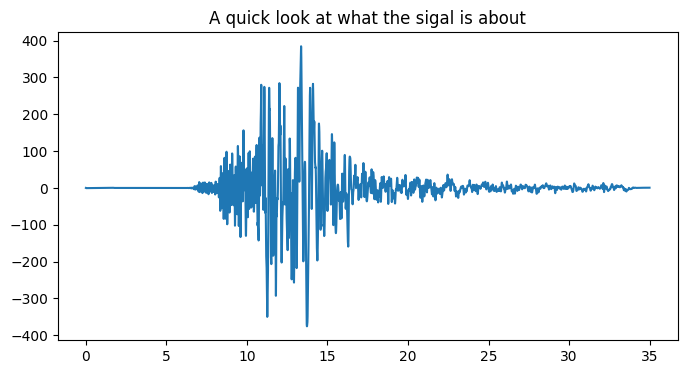

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(epsd_est.t_axis, epsd_est.target_signal)
ax.set_title("A quick look at what the sigal is about")
plt.show()

In [20]:
# as an effort to standarize the uses of EPSD from STFT and wavelet transform

SpecBundle = namedtuple('SpecBundle', ['epsd', 'freq', 't_axis'])

## Compute the global PSD by `Welch`

In [57]:
# f, Pxx = siganl.welch()

PSD = signal.welch(
            epsd_est.target_signal,
            fs=epsd_est.Fs,
            nperseg=512,
            window='hann',
            scaling='density',
            return_onesided=True)

(0.0, 25.0)

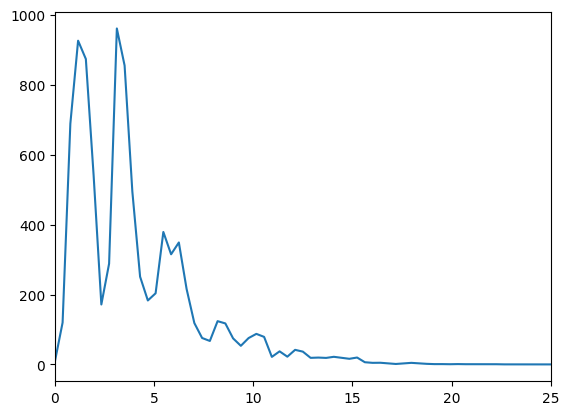

In [59]:
plt.plot(PSD[0], PSD[1])
plt.xlim([0, 25])

## Compute the EPSD and generate SRM simulations

#### 1. STFT

Call `signal.spectrogram` on the signal to compute the specrogram, as an approximate to the EPSD

In [21]:
f, t, Sxx = signal.spectrogram(
                epsd_est.target_signal,
                fs=epsd_est.Fs,
                nperseg=epsd_est.NPERSEG_4EPSD,
                window='hann',
                noverlap=epsd_est.NOVERLAP_4EPSD,
                nfft=epsd_est.NFFT_4EPSD,
                mode='psd')

STFT_epsd = SpecBundle(epsd=Sxx, freq=f, t_axis=t)

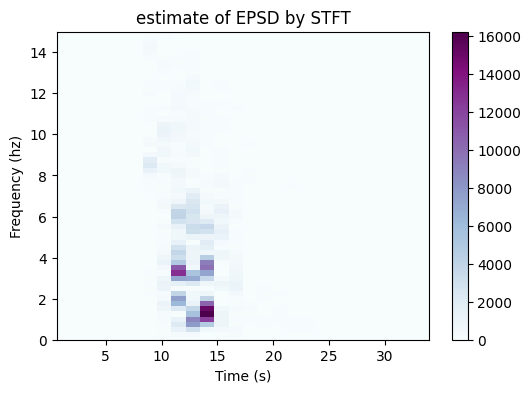

In [23]:
EPSD_show(*STFT_epsd, format='2d', title_name='estimate of EPSD by STFT')

In [27]:
# explicitly show the EPSD shape
STFT_epsd.epsd.shape

(401, 26)

**Hint**:

Since the EPSD by STFT has a small shape, then we need to interpolate it 

In [28]:
STFT_simu_obj = SRM(
        wu=(epsd_est.Fs/2)*2*np.pi, 
        N1=2048, 
        fs=int(epsd_est.Fs), 
        duration=35)

In [31]:
console.print(STFT_simu_obj)

*** Generation started by SRM ***
cutoff frequency wu (rad/s): 628.32
the expected shape of Swt (w, t) axes: ((2048,), (7000,))
the lower limit of sampling frequency (Hz): 200.0

In [32]:
##### simulate an ensemble of generations #####
STFT_ensemble_generations = STFT_simu_obj.nonsta_esmb_simus(
        Pxx=STFT_epsd.epsd, 
        freqs=STFT_epsd.freq, 
        t_bins=STFT_epsd.t_axis, 
        ensemble_num=100)

[<matplotlib.lines.Line2D object at 0x7f8dfd3a3f70>]

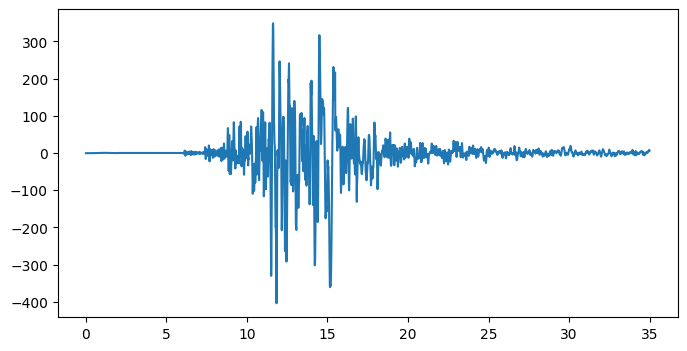

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(STFT_simu_obj.t_axis_4simu, STFT_ensemble_generations[3])

**Summary:**

- The realizations look real enough

In [42]:
Wavlet_epsd = CWTx(
    signal=epsd_est.target_signal, 
    fs=epsd_est.Fs, 
    t_axis=epsd_est.t_axis)

In [43]:
Wavlet_epsd

<StoSpecRep.waveletEPSD.CWTx object at 0x7f8dfd3fd820>

In [45]:
# propose scales to use
Wavlet_epsd.propose_scales(a=2, b=10, num=600)

You've proposed scales:

(a=2,b=10) ==> scales_range(4.0, 1024.0) ==> FreqRange(low=0.15869140625, high=40.625)

In [46]:
# compute EPSD by wavelet transform
Wavlet_epsd.computeEPSD()

Yo! Computing EPSD with the proposed scales

Swt shape: (600, 7000)

(0.0, 14.0)

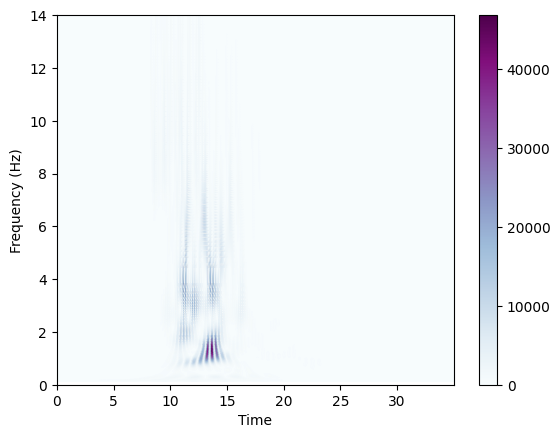

In [55]:
Wavlet_epsd.plot_waveletEPSD(option='2d')
plt.ylim([0, 14])

In [47]:
# wavelet EPSD sample generations
wavelet_ensemble_simus = Wavlet_epsd.g_ensemble_simus(200)

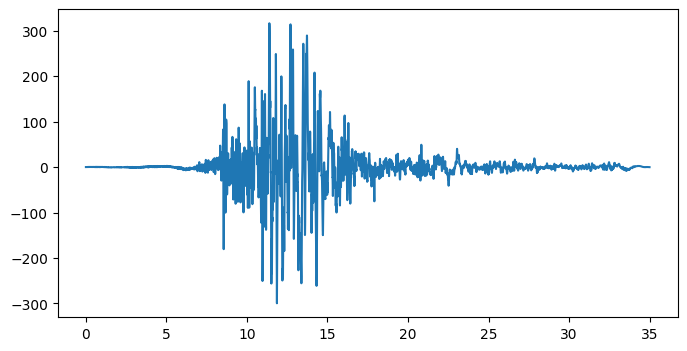

In [54]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Wavlet_epsd.t_axis, wavelet_ensemble_simus[9])
plt.show()